In [1]:
%reload_ext autoreload
%autoreload 2

import sys, os
sys.path.append("..")

import numpy as np
import healpy as hp

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file("matplotlibrc")

In [2]:
from utils.cart import to_cart
from utils.map_utils import downsample

In [8]:
def load_data(name, pipeline='gppe', **kwargs):
    """Return cartesian maps with increasing l and b (use np.flip in plt.imshow to plot view on sky)."""
    
    if pipeline == 'gppe':
        
        fn_dict = {
            'counts' : 'fermidata_counts.npy',
            'exposure' : 'fermidata_exposure.npy',
            'pscmask_4fgl' : 'fermidata_pscmask_4fgl.npy',
            'bubble' : 'template_bub.npy',
        }
        z_hp = np.load(f"../data/fermi_data_573w/fermi_data_256/{fn_dict[name]}")
        
        pixelsize = 0.5
        extent = 20
        n_pixels = int(2 * extent / pixelsize)
        
        return to_cart(z_hp, n_pixels=n_pixels, pixelsize=pixelsize)
        
    elif pipeline == 'gcepy':
        
        fn_dict = {
            'counts' : 'fermi_w009_to_w670_front_only_14_Ebin_20x20window_normal.npy',
            'exposure' : 'isotropic_front_only_14_Ebin_20x20window_normal.npy',
            'pscmask_4fgl' : 'mask_4FGL-DR2_14_Ebin_20x20window_normal.npy',
            'bubble' : 'bubble_front_only_14_Ebin_20x20window_normal.npy',
            #'errors' : 'external_errors.npy',
        }
        z = np.load(f"../data/external/gcepy/inputs/utils/{fn_dict[name]}")
        if name == 'pscmask_4fgl':
            z = 1 - z
        mode = 'sum' if name in ['counts', 'exposure'] else 'average'
        
        ie = 10 if 'ie' not in kwargs else kwargs['ie']
        return np.fliplr(downsample(z[ie], 5, mode=mode))
    
    else:
        raise NotImplementedError

In [4]:
names = ['counts', 'exposure', 'pscmask_4fgl', 'bubble']
pipelines = ['gppe', 'gcepy']

data = {pipeline: {name: load_data(name, pipeline=pipeline) for name in names} for pipeline in pipelines}

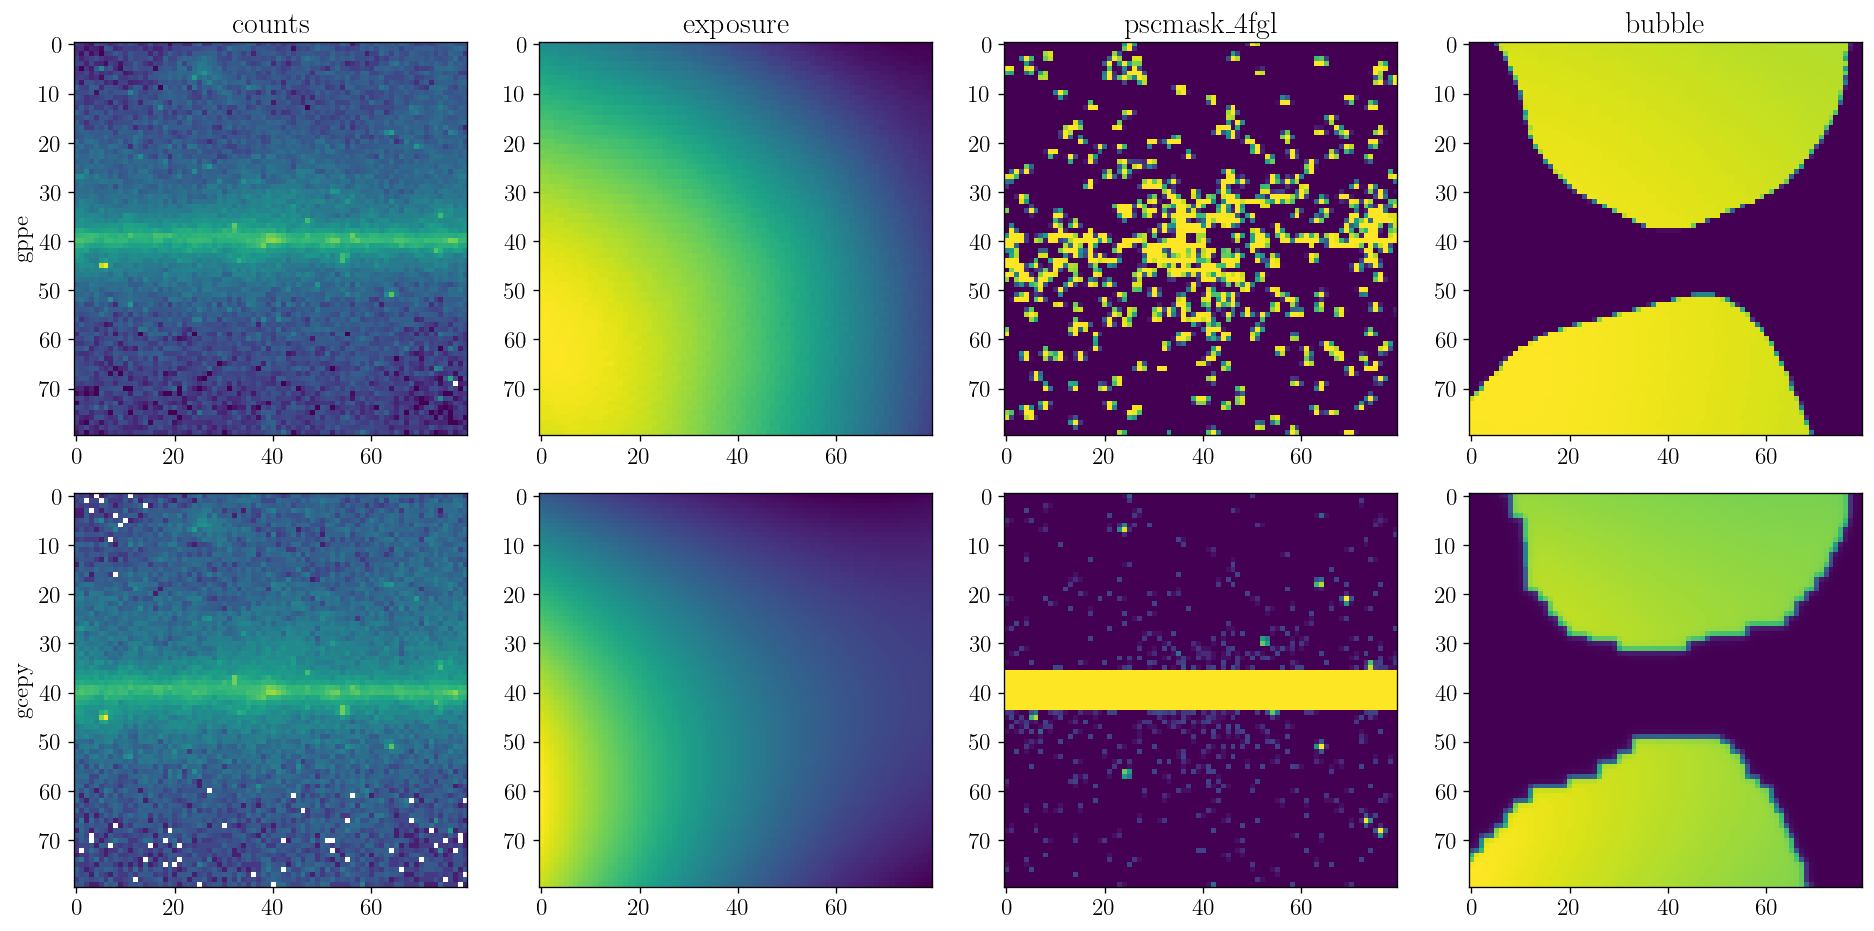

In [5]:
fig, axs = plt.subplots(len(pipelines), len(names), figsize=(4*len(names), 4*len(pipelines)), tight_layout=True)

for i_col, name in enumerate(names):
    for i_row, pipeline in enumerate(pipelines):
        
        z = data[pipeline][name]
        if name in ['counts']:
            norm = mpl.colors.LogNorm(vmin=0.5, vmax=np.max(z))
        else:
            norm = mpl.colors.Normalize(vmin=np.min(z), vmax=np.max(z))
        
        axs[i_row, i_col].imshow(np.flip(data[pipeline][name]), norm=norm)
        
        if i_col == 0:
            axs[i_row, 0].set(ylabel=pipeline)
    axs[0, i_col].set_title(name, fontsize=18)

## tmp

In [12]:
iso_err, bub_err = np.load('../data/external/gcepy/inputs/utils/external_errors.npy')

In [13]:
iso_err

array([0.25801766, 0.23048516, 0.26152277, 0.2831205 , 0.60060453,
       0.4286156 , 0.31768554, 0.46052   , 0.48756853, 0.5124483 ,
       0.502637  , 0.46771753, 0.33897364, 0.3589409 ], dtype=float32)

In [14]:
bub_err

array([0.57092106, 0.5123915 , 0.48382336, 0.4604756 , 0.42673275,
       0.4008505 , 0.37687424, 0.32775664, 0.2723569 , 0.30788392,
       0.34547687, 0.29276702, 0.21491434, 0.23487099], dtype=float32)

## Note

gcepy and our counts map are related by fliplr